In [97]:
# import linecache
# import numpy as np
# def load_raw_audio(size):
#     audio=[]
#     filenames=[]
#     transcript=[]
#     for speaker in os.listdir("../dataset/dev/dev-clean/"):
#         for chapter in os.listdir("../dataset/dev/dev-clean/"+speaker):
#             for filename in os.listdir("../dataset/dev/dev-clean/"+speaker+"/"+chapter):
#                 if filename.endswith(".flac"):
#                     audio.append(spectrogram_from_file("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename))
#                     line = linecache.getline("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+"".join(list(filename)[:-10])+".trans.txt", int("".join(list("".join(list(filename)[:-5]))[-4:]))+1)
#                     transcript.append(line)
#                     filenames.append("".join(list(filename)[:-5]))
#                 if len(audio)>size:
#                     break
#     return audio,filenames,transcript

In [98]:
# def transcript_cleaner(transcript):
#     for i in range(len(transcript)):
#         transcript[i]=transcript[i].split(' ',1)[1]
# transcript_cleaner(trans_dev)

In [99]:
# def transcript_to_index(transcript):
#     transcript_to_index=[]
#     for line in transcript:
#         line_to_index=[]
#         for character in list(line)[:-1]:
#             if character==' ':
#                 character='<SPACE>'
#             line_to_index.append(char_map[character])
#         transcript_to_index.append(line_to_index)
#     return transcript_to_index

In [170]:
char_map_str = """
' 1
<SPACE> 2
A 3
B 4
C 5
D 6
E 7
F 8
G 9
H 10
I 11
J 12
K 13
L 14
M 15
N 16
O 17
P 18
Q 19
R 20
S 21
T 22
U 23
V 24
W 25
X 26
Y 27
Z 28
"""
char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[2] = ' '

In [171]:
from numpy.lib.stride_tricks import as_strided
import soundfile
from matplotlib import pyplot as plt
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):

    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [172]:
def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14,input_length=400000):
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        if len(audio)>input_length:
            audio = audio[:input_length]
        else:
            audio = np.pad(audio, (0, max(0, input_length - len(audio))), "constant")
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
        spec=np.transpose(np.log(pxx[:ind, :] + eps))

    return spec

In [173]:
import linecache
import numpy as np
import pandas as pd
def load_all_data():
    #audio=[]
    #filenames=[]
    #transcript=[]
    data=[]
    for speaker in os.listdir("../dataset/dev/dev-clean/"):
        for chapter in os.listdir("../dataset/dev/dev-clean/"+speaker):
            for filename in os.listdir("../dataset/dev/dev-clean/"+speaker+"/"+chapter):
                if filename.endswith(".flac"):
                    #audio.append(spectrogram_from_file("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename))
                    line = linecache.getline("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+"".join(list(filename)[:-10])+".trans.txt", int("".join(list("".join(list(filename)[:-5]))[-4:]))+1)
                    #transcript.append(line)
                    #filenames.append("".join(list(filename)[:-5]))
                    source="./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename
                    sample=(source,line)
                    data.append(sample)
    #df = pd.DataFrame(data, columns = ['source','transcript'])
    return data

In [180]:
def process_input_file(sample):
    source,transcript=sample
    
    transcript=transcript.split(' ',1)[1]
    # print(transcript)
    # print(source)
    line_to_index=[]
    for character in list(transcript)[:-1]:
        if character==' ':
                character='<SPACE>'
        line_to_index.append(char_map[character])
    processed_input=(spectrogram_from_file(source),line_to_index)
    return processed_input

2703
(401,)
[17, 8, 22, 7, 16, 2, 25, 17, 23, 14, 6, 2, 10, 7, 2, 3, 24, 3, 11, 14, 2, 10, 11, 15, 21, 7, 14, 8, 2, 17, 8, 2, 3, 16, 27, 2, 21, 18, 7, 5, 11, 3, 14, 2, 9, 20, 3, 5, 7, 2, 17, 8, 2, 10, 11, 21, 2, 17, 25, 16, 2, 11, 6, 11, 17, 15, 2, 3, 16, 6, 2, 7, 18, 17, 5, 10, 2, 11, 8, 2, 17, 16, 14, 27, 2, 10, 11, 21, 2, 25, 11, 14, 14, 2, 4, 7, 14, 17, 16, 9, 7, 6, 2, 22, 17, 2, 10, 11, 15, 2, 17, 8, 22, 7, 16, 2, 25, 17, 23, 14, 6, 2, 21, 17, 15, 7, 2, 5, 3, 6, 7, 16, 5, 7, 2, 21, 7, 20, 24, 7, 2, 10, 11, 15, 2, 4, 23, 22, 2, 8, 17, 20, 2, 10, 11, 21, 2, 3, 23, 22, 10, 17, 20, 1, 21, 2, 21, 22, 20, 23, 5, 22, 23, 20, 7, 2, 21, 17, 15, 7, 2, 21, 22, 20, 23, 5, 22, 23, 20, 7, 2, 4, 23, 22, 2, 8, 17, 20, 2, 10, 11, 21, 2, 3, 23, 22, 10, 17, 20, 1, 21, 2, 5, 3, 6, 7, 16, 5, 7, 2, 17, 8, 22, 7, 16, 2, 22, 10, 7, 2, 4, 7, 3, 23, 22, 11, 8, 23, 14, 2, 22, 23, 20, 16, 2, 17, 8, 2, 3, 2, 21, 22, 3, 16, 28, 3, 2, 15, 23, 21, 22, 2, 4, 7, 2, 25, 7, 3, 13, 7, 16, 7, 6, 2, 22, 17, 2, 3, 6, 17

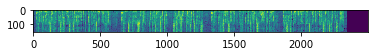

In [181]:
data=load_all_data()
print(len(data))
spec,text=process_input_file(data[0])
print(np.shape(text))
print(text)
plt.imshow(np.transpose(spec))
print(spec.shape)

In [183]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,batch_size=256,shuffle=True,dim=(2499,161)):
        'Initialization'
       
        self.batch_size = batch_size
        self.shuffle = shuffle        
        self.data=data
        self.data=load_all_data()
        self.list_IDs = np.arange(len(data))
        self.on_epoch_end()
        self.dim=dim

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.list_IDs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size), dtype=list)
        #print("hello")
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x,y=process_input_file(self.data[i])
            #print("hello")
            #print(y)
            X[i,]=x
            Y[i]=y          

        return X, Y

In [184]:
train_gen=DataGenerator(batch_size=10)
X,y=train_gen.__getitem__(0)

In [185]:
print(np.shape(X),np.shape(y))

(10, 2499, 161) (10,)


[17, 8, 22, 7, 16, 2, 25, 17, 23, 14, 6, 2, 10, 7, 2, 3, 24, 3, 11, 14, 2, 10, 11, 15, 21, 7, 14, 8, 2, 17, 8, 2, 3, 16, 27, 2, 21, 18, 7, 5, 11, 3, 14, 2, 9, 20, 3, 5, 7, 2, 17, 8, 2, 10, 11, 21, 2, 17, 25, 16, 2, 11, 6, 11, 17, 15, 2, 3, 16, 6, 2, 7, 18, 17, 5, 10, 2, 11, 8, 2, 17, 16, 14, 27, 2, 10, 11, 21, 2, 25, 11, 14, 14, 2, 4, 7, 14, 17, 16, 9, 7, 6, 2, 22, 17, 2, 10, 11, 15, 2, 17, 8, 22, 7, 16, 2, 25, 17, 23, 14, 6, 2, 21, 17, 15, 7, 2, 5, 3, 6, 7, 16, 5, 7, 2, 21, 7, 20, 24, 7, 2, 10, 11, 15, 2, 4, 23, 22, 2, 8, 17, 20, 2, 10, 11, 21, 2, 3, 23, 22, 10, 17, 20, 1, 21, 2, 21, 22, 20, 23, 5, 22, 23, 20, 7, 2, 21, 17, 15, 7, 2, 21, 22, 20, 23, 5, 22, 23, 20, 7, 2, 4, 23, 22, 2, 8, 17, 20, 2, 10, 11, 21, 2, 3, 23, 22, 10, 17, 20, 1, 21, 2, 5, 3, 6, 7, 16, 5, 7, 2, 17, 8, 22, 7, 16, 2, 22, 10, 7, 2, 4, 7, 3, 23, 22, 11, 8, 23, 14, 2, 22, 23, 20, 16, 2, 17, 8, 2, 3, 2, 21, 22, 3, 16, 28, 3, 2, 15, 23, 21, 22, 2, 4, 7, 2, 25, 7, 3, 13, 7, 16, 7, 6, 2, 22, 17, 2, 3, 6, 17, 18, 22, 2,

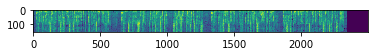

In [188]:
print(y[0])
plt.imshow(np.transpose(X[0]))